``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

## Usando CNNs para classificação

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar celular adicionais para realizar testes, utilizando variaveis auxiliares para visualizar resultados intermediários.```

### 01 - Imports

In [23]:
%%capture
!pip install torchsummary

In [24]:
# modelagem e dados
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils import data

# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# outros
import zipfile
import os
import glob
import numpy as np

### 02 - Datasets e Dataloaders

O dataset utilizado para esse exemplo é CIFAKE: uma dataset com 120000 imagens com 50% sendo verdadeiras (provindas da dataset CIFAR-10) e 50% sendo geradas por Stable Diffusion (fakes).


In [25]:
%%capture
!wget https://www.dropbox.com/scl/fi/fjto0e19s54c13ucezzch/cifake.zip?rlkey=s0b5diqzw5f8vguklapfnfsc6&dl=0

In [26]:
def extract_file(src_file, dst_folder="cifake"):
  if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
  with zipfile.ZipFile(src_file, 'r') as zip_ref:
    zip_ref.extractall(dst_folder)

In [27]:
filename = glob.glob("*.zip*")[0]
extract_file(filename)
os.remove(filename)

Q1 - Usando o transforms.Compose defina um conjunto de transformação que devem ser aplicadas no conjunto de treino e no conjunto de validação. (+10)

Transformações de treino:
- Transformar para tensor
- ColoJitter (b=.5, hue=.3)
- RandomRotation (0, 180)
- RandomHorizontalFlip (p=0.5)
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

Transformações da validação:
- Transormar para tensor
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

https://pytorch.org/vision/0.9/transforms.html

In [28]:
# Adicionar transformacoes para treino e validacao

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.ColorJitter(brightness=.5, hue=.3),
                                      transforms.RandomRotation((0,180)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
                                      ])

transform_eval  = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
                                      ])

In [29]:
def train_val_split(dataset, train_percentage=0.85):
    global transform, transform_eval
    length = len(dataset)
    indices = list(range(length))
    np.random.shuffle(indices)
    len_train = int(np.floor(train_percentage * length))
    train_idx, val_idx = indices[:len_train], indices[len_train:]
    return train_idx, val_idx

Q2 - Crie os dataloaders para carregar os dados dos datasets gerados (train_ds, val_ds, test_ds) (+10)
- Crie os loaders utilizado batch=64 para treino e batch=128 para teste/validação
- use shuffle=True, num_workers=2 e pin_memory=True

In [30]:

train_ds = datasets.ImageFolder(root="cifake/train", transform=transform_train)

val_ds = datasets.ImageFolder(root="cifake/train", transform=transform_eval)
train_idx, val_idx = train_val_split(train_ds)
train_ds = data.Subset(train_ds, train_idx)
val_ds = data.Subset(val_ds, val_idx)

test_ds = datasets.ImageFolder(root="cifake/test", transform=transform_eval)

In [43]:
# Gere os dataloaders para iterar sobre os datasets

train_batch = 64
val_batch = 128
test_batch = 128


train_dl = data.DataLoader(train_ds, batch_size=train_batch, shuffle=True, num_workers=2, pin_memory=True)

val_dl = data.DataLoader(val_ds, batch_size=val_batch, shuffle=True, num_workers=2, pin_memory=True)

test_dl = data.DataLoader(test_ds, batch_size=test_batch, shuffle=True, num_workers=2, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 03 - Visualizando os exemplos

Shape of ins torch.Size([128, 3, 32, 32])


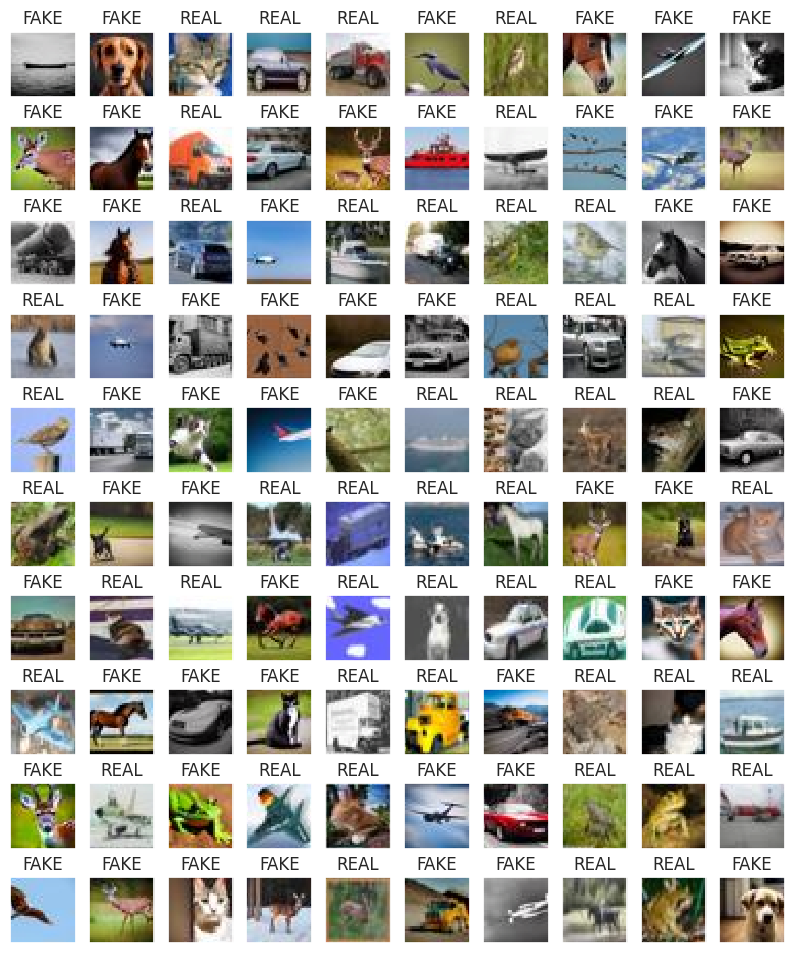

In [32]:
instances, targets = next(iter(test_dl))

inv_norm = transforms.Normalize(
    mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std = [1 / 0.229, 1 / 0.224, 1 / 0.225]
)
ins = inv_norm(instances)

print("Shape of ins {}" .format(ins.shape))

w = 10
fig, ax = plt.subplots(w, w, figsize=(10, 12))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(ins[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = int(targets[i * w + j].item())
    ax[i][j].set_title(test_ds.classes[label])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

## 04 - Gerando o modelo

Q3 - Crie o modelo de classificação
Defina a classe MyCNN que herda de nn.Module (+30)

na função `__init__`defina a arquitetura,
 - Use nn.Sequential para gerar o modelo
 - Camadas:\
    - Conv2d: in_features=3, out_features=16, k=3
    - ReLU
    - Conv2d: in_features=16, out_features=32, k=3
    - ReLU
    - MaxPool2d: k=2, s=2
    - Conv2d: in_features=32, out_features=32, k=3
    - ReLU
    - Conv2d: in_features=32, out_features=32, k=3
    - ReLU
    - MaxPool2d: k=2, s=2
    - Flatten
    - Linear: out_features=256
    - ReLU
    - Dropot: p=0.5
    - Linear: out_features=256
    - ReLU
    - Dropout: p=0.5
    - Linear: out_features=1
    - Sigmoid

- use o `forward` para executar o modelo a partir do atributo Sequential

In [ ]:
# Implemente o modelo especificado acima

class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    self.layers = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Flatten(),
                                nn.Linear(2048, 256),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(256, 256),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(256, 1),
                                nn.Sigmoid(),
                                )
  def forward(self, input):
    return self.layers(input)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
classifier = MyCNN().to(device)

summary(classifier, input_size=(3,32,32), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 32, 32]             448
              ReLU-2           [64, 16, 32, 32]               0
            Conv2d-3           [64, 32, 32, 32]           4,640
              ReLU-4           [64, 32, 32, 32]               0
         MaxPool2d-5           [64, 32, 16, 16]               0
            Conv2d-6           [64, 32, 16, 16]           9,248
              ReLU-7           [64, 32, 16, 16]               0
            Conv2d-8           [64, 32, 16, 16]           9,248
              ReLU-9           [64, 32, 16, 16]               0
        MaxPool2d-10             [64, 32, 8, 8]               0
          Flatten-11                 [64, 2048]               0
           Linear-12                  [64, 256]         524,544
             ReLU-13                  [64, 256]               0
          Dropout-14                  [

## 05 - Treinamento

Q4 - Defina a função de loss e o otimizador (+10)

- Use a loss BCE
- use o otimizador ADAM (lr=1E-4)

https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
#defina a função de loss e otimizador
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

In [35]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
def train_step(model, train_dl, loss_fn, optimizer, device):

  model.train()

  train_loss = AverageMeter()
  for sample, target in train_dl:
    sample = sample.to(device)
    target = target.to(device)

    optimizer.zero_grad()
    output = model(sample).flatten()
    loss = loss_fn(output, target.float())
    train_loss.update(loss.item(), len(sample))
    loss.backward()
    optimizer.step()
  return train_loss.avg

def validation_step(model, val_dl, loss_fn, device):
  model.eval()
  val_loss=AverageMeter()

  with torch.no_grad():
    for sample, target in val_dl:
      sample = sample.to(device)
      target = target.to(device)

      output = model(sample).flatten()
      loss = loss_fn(output, target.float())
      val_loss.update(loss.item(), len(sample))
  return val_loss.avg

In [ ]:
history_cs = {
    "train_loss": [],
    "val_loss": []
}

EPOCHS = 15

for epoch in range(EPOCHS):
  train_loss = train_step(classifier, train_dl, loss_fn, optimizer, device)
  val_loss   = validation_step(classifier, val_dl, loss_fn, device)

  history_cs["train_loss"].append(train_loss)
  history_cs["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")


Época [1/15]
-----------------------------------
Train loss: 0.523467
Valid. loss: 0.405428

Época [2/15]
-----------------------------------
Train loss: 0.408862
Valid. loss: 0.334332

Época [3/15]
-----------------------------------
Train loss: 0.37764
Valid. loss: 0.318871

Época [4/15]
-----------------------------------
Train loss: 0.358448
Valid. loss: 0.293612

Época [5/15]
-----------------------------------
Train loss: 0.345776
Valid. loss: 0.279614

Época [6/15]
-----------------------------------
Train loss: 0.333936
Valid. loss: 0.293898

Época [7/15]
-----------------------------------
Train loss: 0.324992
Valid. loss: 0.287314

Época [8/15]
-----------------------------------
Train loss: 0.314412
Valid. loss: 0.262728

Época [9/15]
-----------------------------------
Train loss: 0.305998
Valid. loss: 0.248069

Época [10/15]
-----------------------------------
Train loss: 0.302419
Valid. loss: 0.250666

Época [11/15]
-----------------------------------
Train loss: 0.294025

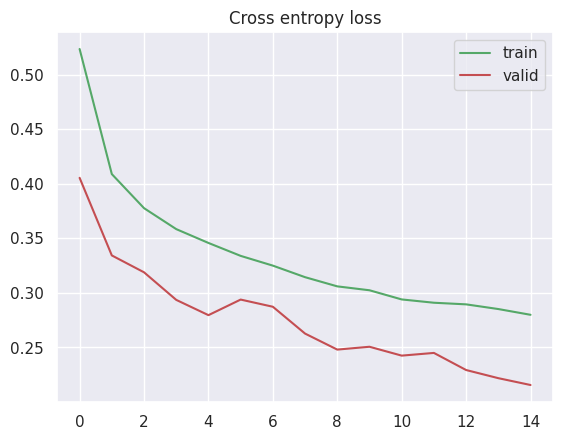

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history_cs["train_loss"], c="g", label="train")
plt.plot(history_cs["val_loss"], c="r", label="valid")
plt.legend()

## 06 - Tranfer Learning

Q5 - utilize a resnet50 para realizar o transfer learning no dataset avaliado (+20)

- Use a resnet50 do torch (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)
- inicialize o modelo com pesos no imagenet (ResNet50_Weights.IMAGENET1K_V2)
- congele os parameteros da arquitetura (requires_grad=False)
- defina um classficador usando nn.Sequential
  - O classificador deve conter as camadas: Linear(resnet50.fc.in_features, 256), ReLU(), Linear(256, 1), Sigmoid()
- atribua o classficador em resnet50.fc
- transfira o modelo para o device do ambiente

In [37]:
resnet50 = models.resnet50(pretrained=True)

print(resnet50)

for name, parameter in resnet50.named_parameters():
    if 'fc' not in name:
        parameter.requires_grad = False

resnet50.fc = nn.Sequential(nn.Linear(resnet50.fc.in_features, 256),
                            nn.ReLU(),
                            nn.Linear(256, 1),
                            nn.Sigmoid(),
                            )

classifier_tl = resnet50
classifier_tl.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
summary(classifier_tl, input_size=(3,224,224), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

Q6 - Usando o transforms.Compose defina um conjunto de transformação que devem ser aplicadas no conjunto de treino e no conjunto de validação. (+10)

Transformações de treino:
- Resize (224)
- Transformar para tensor
- ColorJitter (b=.5, hue=.3)
- RandomRotation (0, 180)
- RandomHorizontalFlip (p=0.5)
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

Transformações da validação:
- Resize (224)
- Transormar para tensor
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

https://pytorch.org/vision/0.9/transforms.html

In [45]:
transform_train_tl = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.ColorJitter(brightness=.5, hue=.3),
                                         transforms.RandomRotation((0,180)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
                                         ])

transform_eval_tl  = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
                                         ])

In [46]:
train_dl.dataset.transform = transform_train_tl
val_dl.dataset.transform = transform_eval_tl

Q7 - Defina o loss (BCE) e o otimizador com os parâmetros do novo modelo (+10)

In [47]:
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier_tl.parameters(), lr=learning_rate)

In [48]:
N_EPOCHS_TL = 15

history_tl = {
    "train_loss": [],
    "val_loss": []
}

for epoch in range(N_EPOCHS_TL):
  train_loss = train_step(classifier_tl, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(classifier_tl, val_dl, loss_fn, device)

  history_tl["train_loss"].append(train_loss)
  history_tl["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{N_EPOCHS_TL}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/15]
-----------------------------------
Train loss: 0.530405
Valid. loss: 0.633313

Época [2/15]
-----------------------------------
Train loss: 0.511933
Valid. loss: 0.577811

Época [3/15]
-----------------------------------
Train loss: 0.503408
Valid. loss: 0.536855

Época [4/15]
-----------------------------------
Train loss: 0.496976
Valid. loss: 0.582341

Época [5/15]
-----------------------------------
Train loss: 0.490651
Valid. loss: 0.569502

Época [6/15]
-----------------------------------
Train loss: 0.485532
Valid. loss: 0.582206

Época [7/15]
-----------------------------------
Train loss: 0.485333
Valid. loss: 0.546184

Época [8/15]
-----------------------------------
Train loss: 0.483258
Valid. loss: 0.787729

Época [9/15]
-----------------------------------
Train loss: 0.478926
Valid. loss: 0.519619

Época [10/15]
-----------------------------------
Train loss: 0.476967
Valid. loss: 0.518347

Época [11/15]
-----------------------------------
Train loss: 0.47312

## 07 - Testando arquitetura propria (MyCNN)

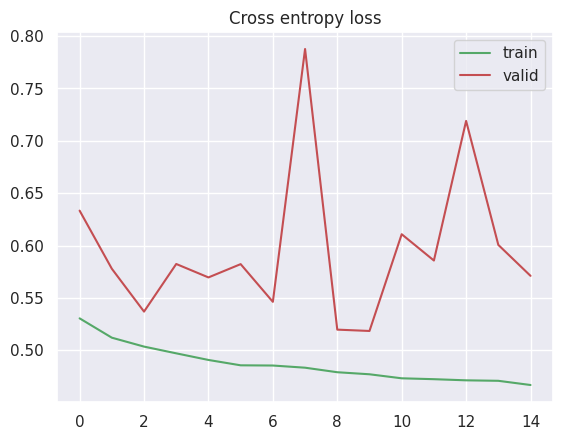

In [49]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history_tl["train_loss"], c="g", label="train")
plt.plot(history_tl["val_loss"], c="r", label="valid")
plt.legend()

In [ ]:
test_dl.dataset.transform = transform_eval
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        preds = classifier(test_instances)
    preds[preds > 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))

preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

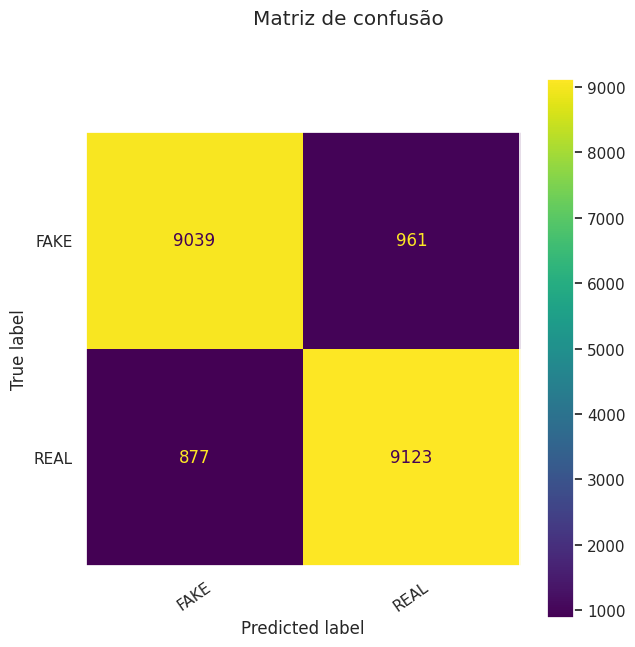

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.91      0.90      0.91     10000
        REAL       0.90      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



## 08 - Testando modelo com transfer learning

In [50]:
test_dl.dataset.transform = transform_eval_tl
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier_tl.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        preds = classifier_tl(test_instances)
    preds[preds > 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))

preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

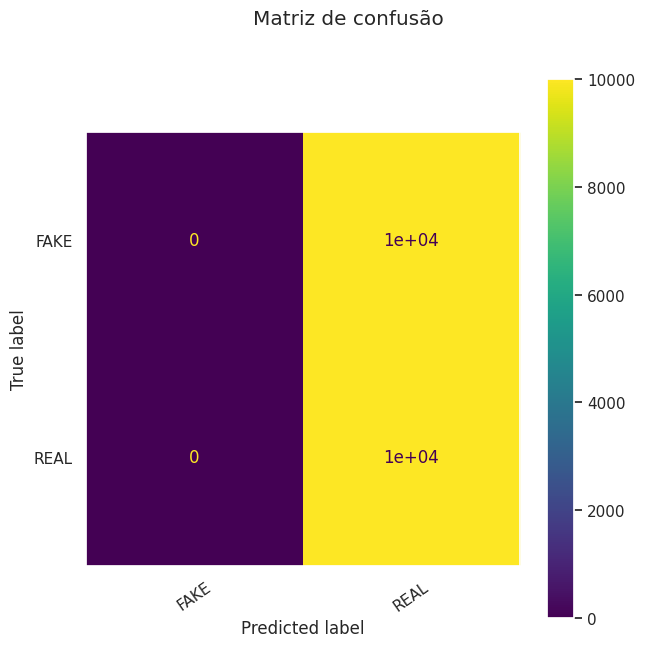

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [52]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00     10000
        REAL       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000

